This notebook first optimizes the size of the pv modules for each house, such that it has an optimal size of the pv module. Optimal is in this case that the cost over a specific time period minimizes. WE WILL NOT USE GA FOR THAT HERE!

After this optimization we integrate an storage network and optimize their sizes and connections to other houses in order to minimize the cost as well. WITH GA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.grid import Grid
import random
from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

### Import datasets
We only choose a single house here for the consumption, while we keep all possibilities of pv modules. We also retrieve the sizes of the pv modules from the production DataFrame.

In [2]:
# Consumption data
df_cons = pd.read_csv('data/consumption_ausgrid.csv')
df_cons['Unnamed: 0'] = pd.to_datetime(df_cons['Unnamed: 0'])
df_cons = df_cons.set_index('Unnamed: 0')
df_cons_red = df_cons.iloc[:,0]
# Production data
df_prod = pd.read_csv('data/normalized_generation_ausgrid_025steps.csv')
df_prod['Unnamed: 0'] = pd.to_datetime(df_prod['Unnamed: 0'])
df_prod = df_prod.set_index('Unnamed: 0')

In [3]:
# Retrieve data from consumption
data_consumption = df_cons_red.values

# Retrieve data from production and pv_sizes
data_production = df_prod.values
pv_peakpowers = [float(key) for key in df_prod.keys()]

# Single Household
### Create a grid model 
This creates a standard grid model, which does not include any storage device (i.e. one storage with zero capacity). Therefore we get the pure consumption data and the price for this consumption. 

In [4]:
g = Grid(num_houses=1,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
g.set_costs() # Set standard costs
res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
print(res_dict)

{'import_grid_kwh': 7679.200999999989, 'export_grid_kwh': 0.0, 'pv_production_kwh': 0.0, 'setup_cost_storage': 0, 'setup_cost_pv': 0.0, 'cost_import_grid': 1919.8002499999973, 'reward_export_grid': 0.0}


###  Objective function 
We now need to define an objective function, that we want to optimize. As outlined before we want to optimize here the cost within a certain time frame (e.g. 7 years). Setting up storages and PV systems are one time expenses, so we just leave them as they result from the model simulation. However the costs and reward from grid interactions are only valid for a single year. Hence we multiply them by the number of years, which we look at, to get an approximation for the total costs.
We can also think of completly different objective functions, such as minimizing the interaction with the grid. Or combinations of costs and grid dependency factors.

In [5]:
def objective_function(res_dict,years=7):
    total_cost = res_dict["setup_cost_storage"] + res_dict["setup_cost_pv"]
    total_cost += res_dict["cost_import_grid"]*years
    total_cost -= res_dict["reward_export_grid"]*years
    return total_cost

Applying the objective function to the model without a PV installation, gives us simply the normal cost for energy in the house over the defined timespan.

In [6]:
total_cost_noPV = objective_function(res_dict)
print(total_cost_noPV)

13438.601749999982


Applying the objective function now to the grid model for all possible PV types gives us a "cost-landscape".


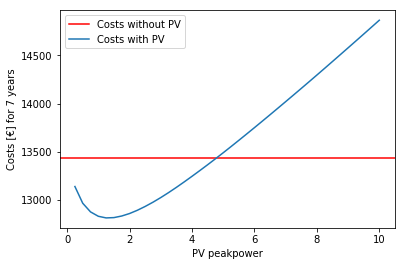

In [7]:
total_costs = []
# For all possible PV types
for i in range(data_production.shape[1]):
    # Set pv type of house to this specific one
    g.change_pvtype(num_house=0,pv_type=i)
    # Simulate the grid for one year
    res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
    # Objective function
    total_costs.append(objective_function(res_dict))
    
# Plot the total costs agains the peakpower of the used module
plt.axhline(total_cost_noPV,c='r',label='Costs without PV')
plt.xlabel('PV peakpower')
plt.ylabel('Costs [€] for 7 years')
plt.plot(pv_peakpowers,total_costs,label='Costs with PV')
plt.legend()
plt.savefig('plots/single_household_7year.png',dpi=200)

The downside of this specific objective function is, that it depends on the timespan. If the timespan is too large (e.g. 15 years), the total cost only decreases with the peakpower of the installed pv module. Hence the largest module is the best. 
Otherwise, if the timespan is too small, the costs only increase with peakpower and no pv module is the cheapest choice.

# Multiple households
Now we are going to do the same as above just for multiple households that all have different consumption schedules. In order to cut down the dimensions we need to use later on we only take the first 20 PV modules as available. These correspond to sizes from $0.25$ kWp to $5.00$ kWp

In [50]:
# Choose number of houses houses
num_houses = 20

# Retrieve data from production and pv_sizes
df_prod = df_prod.iloc[:,0:20]
data_production = df_prod.values
pv_peakpowers = [float(key) for key in df_prod.keys()]

# Create the grid model and simulate one year
g = Grid(num_houses=num_houses,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
# Set standard costs
g.set_costs()

Since the houses are non interacting we can look at each house on its own and optimize its pvtype alone. This will be done with the following block.

In [52]:
min_sum = 0
optimal_pvtypes_houses = np.zeros(num_houses)

for l in range(num_houses):
    data_consumption = df_cons.iloc[:,l].values
    g = Grid(num_houses=1,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
    g.set_costs()
    total_costs = []
    # For all possible PV types
    for i in range(data_production.shape[1]):
        # Set pv type of house to this specific one
        g.change_pvtype(num_house=0,pv_type=i)
        # Simulate the grid for one year
        res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
        # Objective function
        total_costs.append(objective_function(res_dict))
    #plt.subplot(2,3,l+1)
    #plt.plot(pv_peakpowers,total_costs)
    #plt.title('House ' + str(l))
    min_sum += np.min(total_costs)
    optimal_pvtypes_houses[l] = np.argmin(total_costs) 
    #plt.axvline(pv_peakpowers[np.argmin(total_costs)],c='r')
#plt.tight_layout()
#plt.show()
print('Minimum cost: ' + str(min_sum))

Minimum cost: 203213.7392249998


Now we obtained the optimal size of a pv storage for each house. We proceed with setting up a storage system between these houses in order to minimize the cost spend on energy even more.

# Storage system

Above we created a population that has optimal configuration of pv modules for each house. Since this a use case that every single household would consider, we know implement a storage system that is connected to several houses. It might give use some insights in how we should connect houses together, such that they can optimize their energy expenses to even lower amounts in the same timespan. 

In [61]:
# Get the consumption data for all houses used
data_consumption = df_cons.iloc[:,:num_houses].values

# Create the grid for the houses
g = Grid(num_houses=num_houses,
         num_storages=1,
         max_capacity=0,
         num_pvtypes=len(pv_peakpowers),
         pv_peakpower=pv_peakpowers
        )
g.set_costs()

# Change pv types to optimal one
for i in range(num_houses):
    g.change_pvtype(num_house=i,pv_type=optimal_pvtypes_houses[i])
    
# Check that costs are the same as above
res_dict = g.simulate(data_consumption,data_production)
objective_function(res_dict,years=20)

494160.68349999795

Now we can add the storage system to the grid object.

In [65]:
# Update storage system
g.change_storages(num_storages=3,max_capacity=25)

# Check new costs
res_dict = g.simulate(data_consumption,data_production)
objective_function(res_dict,years=20)

476418.17574999674

In [66]:
df_cons.head(5)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,1.149,0.254,1.048,0.090,1.896,0.636,1.860,2.212,1.835,0.814,...,0.446,0.063,2.244,0.396,0.156,0.036,0.182,0.139,0.042,4.460
2012-07-01 00:30:00,2.105,0.167,0.965,0.084,1.905,2.799,1.298,0.208,0.025,0.020,...,0.221,0.075,1.964,0.134,0.075,0.030,0.141,0.157,0.541,2.892
2012-07-01 01:00:00,2.036,0.108,0.927,0.084,1.174,2.749,0.098,0.151,0.022,0.036,...,0.231,0.075,0.827,1.199,0.084,0.053,0.257,0.127,0.100,1.345
2012-07-01 01:30:00,1.854,0.119,1.359,2.012,0.105,2.670,0.064,0.092,0.011,0.009,...,0.247,0.063,0.193,2.069,0.054,0.044,0.197,0.122,0.090,0.134
2012-07-01 02:00:00,1.807,0.150,0.060,2.062,0.075,2.712,0.089,0.152,0.981,1.132,...,0.193,0.444,0.185,2.060,0.062,0.029,1.603,0.120,0.094,0.100
